<a href="https://colab.research.google.com/github/samleonnn/HerAi-Model-Development/blob/main/WasteSegregation_TransferLearning_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-05-14 03:34:09--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   157MB/s    in 0.5s    

2022-05-14 03:34:10 (157 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Capstone C22-PC414/AllMainData_v3.zip", "r")
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
TRAIN_DIR = "/tmp/AllMainData_v3/TRAIN"
VAL_DIR  = "/tmp/AllMainData_v3/VAL"

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, 
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, 
                                   horizontal_flip = True)

# Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                    batch_size=128, 
                                    class_mode="categorical",
                                    target_size=(224, 224))

# Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
# Remember that validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.5)

# Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=VAL_DIR,
                                            batch_size=128, 
                                            class_mode="categorical",
                                            target_size=(224, 224),
                                            subset = "training")

test_generator = validation_datagen.flow_from_directory(directory=VAL_DIR,
                                            batch_size=128, 
                                            class_mode="categorical",
                                            target_size=(224, 224),
                                            subset = "validation")

Found 21249 images belonging to 3 classes.
Found 3212 images belonging to 3 classes.
Found 3211 images belonging to 3 classes.


In [ ]:
print(train_generator.class_indices)

{'Non-Recyclable': 0, 'Organic': 1, 'Recyclable': 2}


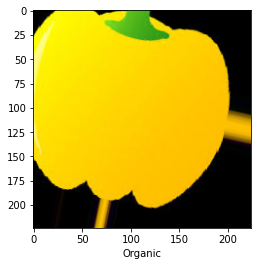

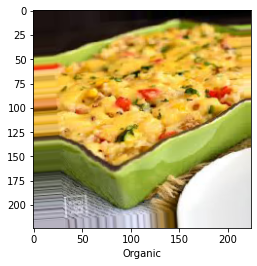

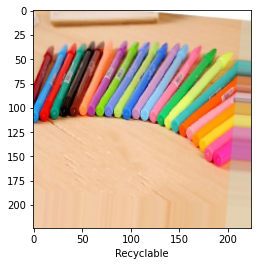

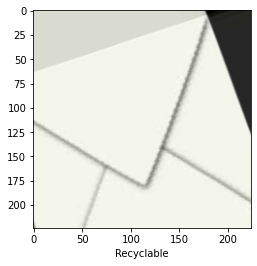

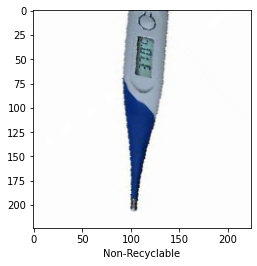

In [ ]:
class_names = ["Non-Recyclable", "Organic", "Recyclable"]
x,y = train_generator.next()

for i in range(5):
    image = x[i]
    label = np.argmax(y[i])
    plt.xlabel(class_names[label])
    plt.imshow(image)
    plt.show()

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(3, activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
opt = "adam"
model.compile(optimizer=opt,
            loss="categorical_crossentropy",
            metrics=['accuracy']) 

In [ ]:
history = model.fit(train_generator,
                    epochs = 10,
                    verbose = 1,
                    validation_data = validation_generator)

Epoch 1/10
167/167 [==============================] - 324s 2s/step - loss: 0.7575 - accuracy: 0.7725 - val_loss: 0.4809 - val_accuracy: 0.7964
Epoch 2/10
167/167 [==============================] - 313s 2s/step - loss: 0.3616 - accuracy: 0.8545 - val_loss: 0.3712 - val_accuracy: 0.8440
Epoch 3/10
167/167 [==============================] - 312s 2s/step - loss: 0.3186 - accuracy: 0.8730 - val_loss: 0.4167 - val_accuracy: 0.8322
Epoch 4/10
167/167 [==============================] - 311s 2s/step - loss: 0.3102 - accuracy: 0.8775 - val_loss: 0.3662 - val_accuracy: 0.8515
Epoch 5/10
167/167 [==============================] - 311s 2s/step - loss: 0.2970 - accuracy: 0.8823 - val_loss: 0.3448 - val_accuracy: 0.8630
Epoch 6/10
167/167 [==============================] - 310s 2s/step - loss: 0.2784 - accuracy: 0.8913 - val_loss: 0.4014 - val_accuracy: 0.8415
Epoch 7/10
167/167 [==============================] - 326s 2s/step - loss: 0.2635 - accuracy: 0.8983 - val_loss: 0.3395 - val_accuracy: 0.8686

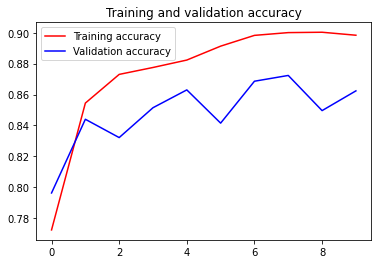

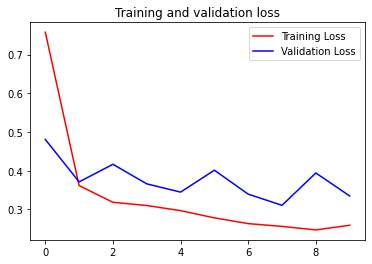

In [ ]:
# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(test_generator)

26/26 [==============================] - 17s 653ms/step - loss: 0.1654 - accuracy: 0.9371


[0.1654169112443924, 0.9370912313461304]

Confusion Matrix


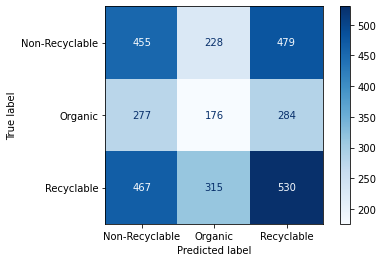


Classification Report
                precision    recall  f1-score   support

Non-Recyclable       0.38      0.39      0.39      1162
       Organic       0.24      0.24      0.24       737
    Recyclable       0.41      0.40      0.41      1312

      accuracy                           0.36      3211
     macro avg       0.34      0.34      0.34      3211
  weighted avg       0.36      0.36      0.36      3211



In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ["Non-Recyclable", "Organic", "Recyclable"]
cm = confusion_matrix(test_generator.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

print()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))